## Ski Rental with Movie Lens
This notebook trains predictors for whether a user will watch more than b movies in the next month. 
We use these raw and calibrated predictors to compare the results of the ski-rental algorithms we propose in our paper.

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme() 
# features
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve


#calibration library
from crepes import WrapRegressor

# metrics
from sklearn.metrics import roc_auc_score
from sklearn import tree

import models as md
import utils as ut
import calibrator as cal
import skirental as sr

%load_ext autoreload 
%autoreload 2

### Section 0: Loading Data

Text(0.5, 1.0, 'Distribution of target values for Bike dataset')

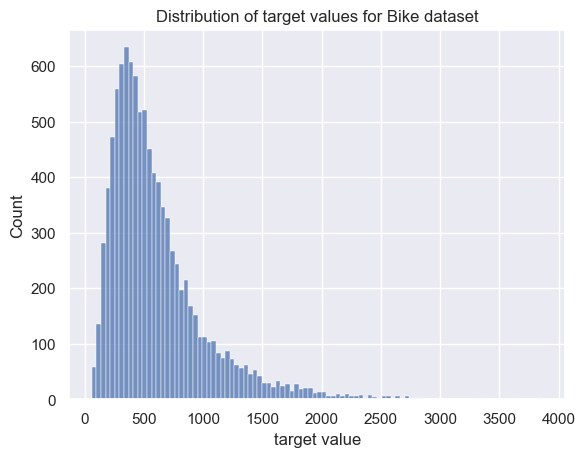

In [58]:
DATASET = 'Bike'

if DATASET == 'Movies': 
    movie_df = pd.read_csv('clean_data/movie_lens100k_monthly.csv')
    y = movie_df['movies_this_month'].values
    # Transform both feature sets
    X_clf = movie_df[['age', 'gender', 'occupation', 'zip', 'movies_watched']]
    X_reg = movie_df[['age', 'gender', 'movies_watched']]

    # Create separate DictVectorizers for each feature set
    vec_clf = DictVectorizer()
    vec_reg = DictVectorizer()

    X_post_clf = vec_clf.fit_transform(X_clf.to_dict('records')).toarray()
    X_post_reg = vec_reg.fit_transform(X_reg.to_dict('records')).toarray()
elif DATASET == 'Bike': 
    n=10000
    bike_df = pd.read_csv('clean_data/citibike-jan2015.csv').dropna().sample(n) 
    joint_df = bike_df #[bike_df['tripduration']<1000]
    # positive = bike_df[bike_df['tripduration'] >= b].sample(int(n/2))
    # negative = bike_df[bike_df['tripduration'] < b].sample(int(n/2))
    # joint_df = pd.concat([positive, negative])

    X = joint_df[['birth year', 'gender', 'usertype', 'start latitude rounded', 'start longitude rounded', 'starthour']]
    y = joint_df['tripduration'].values

    # Create separate DictVectorizers for each feature set
    vec_clf = DictVectorizer()
    vec_reg = DictVectorizer()

    X_post_clf = vec_clf.fit_transform(X.to_dict('records')).toarray()
    X_post_reg = vec_reg.fit_transform(X.to_dict('records')).toarray()

sns.histplot(y)
plt.xlabel('target value')
plt.title(f'Distribution of target values for {DATASET} dataset')

### Section 1: Training & Calibrating Predictors
This section is to verify the achievable accuracy / perforamnce of predictors on this dataset

In [3]:
# training calibrated regression model: 
i=0
X_train, X_test, y_train, y_test = train_test_split(
    X_post_reg, y, test_size=0.20, random_state=i)

X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, y_train, test_size=0.20, random_state=i)

print(f"size train: {len(X_train)}, valid: {len(X_valid)} test: {len(X_test)} ")

for clf in md.reg_dict: 
    start_time = time.time()
    model = Pipeline(
                [
                    ("scalar", StandardScaler()),
                    ("reg", md.reg_dict[clf]())
                ]
            )
    model.fit(X_train, y_train)
    print(f"{clf}: {model.score(X_test, y_test)}")
    rf = WrapRegressor(model)
    rf.fit(X_train, y_train)
    rf.calibrate(X_valid, y_valid)
    for conf in [0.7, 0.8, 0.9, 0.95]: 
        conf_interval = rf.predict_int(X_test, confidence=conf)
        print(f'conf: {conf} interval size: {(conf_interval[:, 1] - conf_interval[:, 0]).mean()}')
    end_time = time.time()
    execution_time = end_time - start_time 
    print(f"Function took {execution_time} seconds to execute\n") 

size train: 178714, valid: 44679 test: 55849 
LR: 0.01394757382465961
conf: 0.7 interval size: 683.5209207521592
conf: 0.8 interval size: 813.4714886934061
conf: 0.9 interval size: 1075.6231683243477
conf: 0.95 interval size: 1640.369376294977
Function took 0.06622910499572754 seconds to execute

BR: 0.013944288403991312
conf: 0.7 interval size: 683.4277395538866
conf: 0.8 interval size: 813.3857640260162
conf: 0.9 interval size: 1075.571429163634
conf: 0.95 interval size: 1640.414192490884
Function took 0.08047223091125488 seconds to execute

XGBR: 0.15566688776016235
conf: 0.7 interval size: 618.6217041015625
conf: 0.8 interval size: 765.0555419921875
conf: 0.9 interval size: 1048.2503662109375
conf: 0.95 interval size: 1467.8558349609375
Function took 1.7804269790649414 seconds to execute

SGDR: 0.01265313043832883
conf: 0.7 interval size: 683.2315706043422
conf: 0.8 interval size: 812.1595946795914
conf: 0.9 interval size: 1073.4998236115464
conf: 0.95 interval size: 1642.574053236

In [4]:
training_results = [] 
num_runs = 1
binary_clfs = {} 
calibrators = {} 
bins = 50 
temp_b = 600
for i in range(num_runs): 
        X_train, X_test, y_train, y_test = train_test_split(
            X_post_clf, y>temp_b, test_size=0.20, random_state=i)

        X_train, X_valid, y_train, y_valid = train_test_split(
                X_train, y_train, test_size=0.20, random_state=i)

        for name in md.clf_dict: 
            start_time = time.time()
            curr_clf = md.model_choice(name, X_train, y_train)
            curr_clf.fit(X_train, y_train)
            probs = curr_clf.predict_proba(X_test)[:, 1]
            _, _, ece_l1, ece_l2, alpha, = ut.expected_calibration_error(prob_true=np.asarray(y_test), 
                                                                 prob_pred=np.asarray(probs), 
                                                                 num_bins=bins)
            training_results.append({
                'clf': name, 
                'run': i, 
                'ece_l1': ece_l1, 
                'ece_l2': ece_l2, 
                'alpha': alpha,
                'accuracy': curr_clf.score(X_test, y_test), 
                'auc': roc_auc_score(y_test, probs),
                'calibrated': False
            })
            binary_clfs[name] = curr_clf

            calibrator = cal.BinningCalibrator(bins=bins)
            calibrator.calibrate(curr_clf.predict_proba(X_valid)[:, 1], y_valid)
            y_cal_probs = calibrator.transform(probs)
            _, _, ece_l1, ece_l2, alpha = ut.expected_calibration_error(prob_true=np.asarray(y_test),
                                                                 prob_pred=np.asarray(y_cal_probs),
                                                                 num_bins=bins)
            training_results.append({
                'clf': name, 
                'run': i, 
                'ece_l1': ece_l1, 
                'ece_l2': ece_l2, 
                'alpha': alpha,
                'accuracy': ((y_cal_probs > 0.5) ==  y_test).mean(), 
                'auc': roc_auc_score(y_test, y_cal_probs),
                'calibrated': True
            })
            calibrators[name] = calibrator
            end_time = time.time()
            execution_time = end_time - start_time 
            print(f"{name} took {execution_time} seconds to execute\n")

LR took 0.08118391036987305 seconds to execute

GB took 5.771879196166992 seconds to execute

XGB took 1.0664844512939453 seconds to execute

running model search
KNN took 6.615143775939941 seconds to execute

RF took 10.319655895233154 seconds to execute

running model search
NN took 60.51421093940735 seconds to execute



In [5]:
training_results_df = pd.DataFrame(training_results)

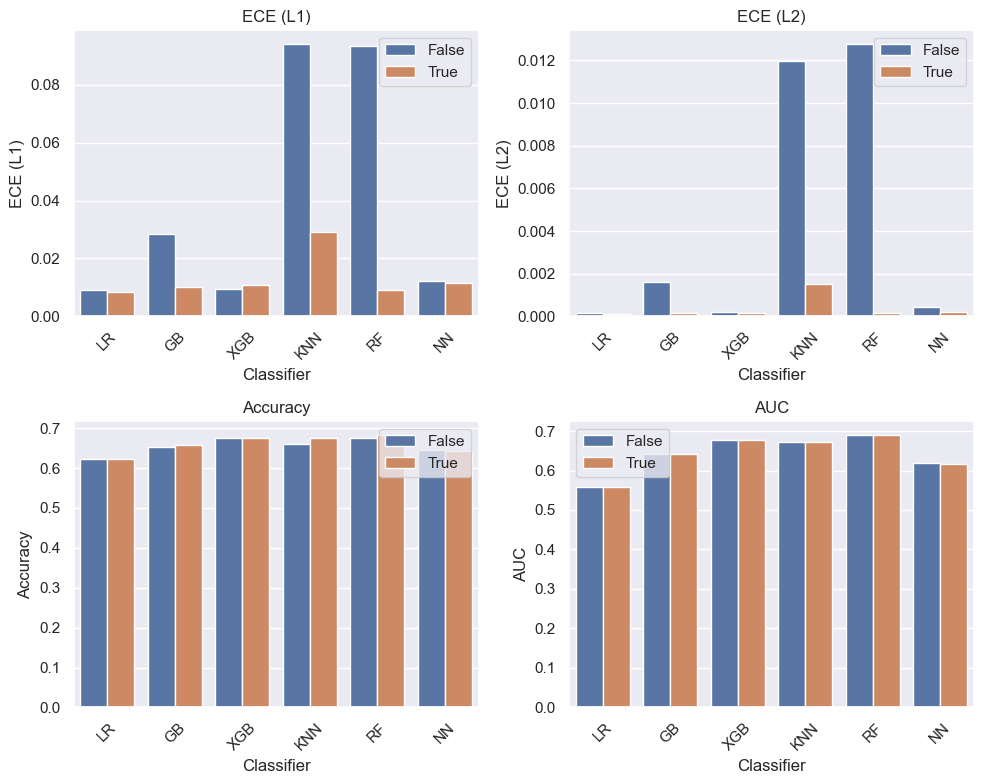

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
metrics = ['ece_l1', 'ece_l2', 'accuracy', 'auc']
titles = ['ECE (L1)', 'ECE (L2)', 'Accuracy', 'AUC']
axes = axes.ravel()

# Create subplots
for idx, (metric, title) in enumerate(zip(metrics, titles)):
    sns.barplot(
        data=training_results_df,
        x='clf',
        y=metric,
        hue='calibrated',
        ax=axes[idx],
    )
    axes[idx].set_title(title)
    axes[idx].set_xlabel('Classifier')
    axes[idx].set_ylabel(title)
    # Rotate x-axis labels for better readability
    axes[idx].tick_params(axis='x', rotation=45)
    # Move legend to a better position
    axes[idx].legend(title='')

# Adjust layout
plt.tight_layout()
plt.show()

### Section 2: Comparing Ski Rental Algorithms

In [63]:
CR_df = []
bins=100
num_runs = 5
conf = 0.9
debug_dict = {} 
for i in range(num_runs):
    indices = np.arange(len(X))
    # First split: separate out test set (20% of data)
    idx_temp, idx_test = train_test_split(
        indices, test_size=0.20, random_state=i
    )

    # Second split: split remaining data into train and validation (0.25 = 20% of original 80%)
    idx_train, idx_valid = train_test_split(
        idx_temp, test_size=0.20, random_state=i
    )

    # regression 
    X_train = X_post_reg[idx_train]
    X_valid = X_post_reg[idx_valid]
    X_test = X_post_reg[idx_test]

    y_train_cont = y[idx_train]
    y_valid_cont = y[idx_valid]
    y_test_cont = y[idx_test]

    # continuous Y
    # reg_model_name = md.get_best_regressor(X_train,
    #                                        y_train,
    #                                        X_valid,
    #                                        y_valid)
    reg_results_df = pd.DataFrame()
    reg_model_name = 'LR'
    model = Pipeline(
        [
            ("scalar", StandardScaler()),
            (reg_model_name, md.reg_dict[reg_model_name]())

        ]
    )
    rf = WrapRegressor(model)
    rf.fit(X_train, y_train_cont)
    rf.calibrate(X_valid, y_valid_cont)

    conf_interval = rf.predict_int(X_test, confidence=conf)

    reg_results_df['reg_pred_cont'] = model.predict(X_test)
    reg_results_df['reg_low_cont'] = np.maximum(conf_interval[:, 0], 1e-3) # avoid negative numbers
    reg_results_df['reg_high_cont'] = conf_interval[:, 1]
    reg_results_df['y'] = y_test_cont

    print("mean conf interval size: ", (conf_interval[:10, 1] - conf_interval[:10, 0]).mean())
    
    for b in [200, 300, 400, 500, 600, 700, 800, 900, 1000]:
        results_df = pd.DataFrame()

        
        y_train = y_train_cont > b 
        y_valid = y_valid_cont > b 
        y_test = y_test_cont > b 
            
        # reg_model_name = md.get_best_regressor(X_train,
        #                                        y_train_reg,
        #                                        X_valid,
        #                                        y_valid_reg)
        reg_model_name = 'LR'
        model = Pipeline(
            [
                ("scalar", StandardScaler()),
                (reg_model_name, md.reg_dict[reg_model_name]())

            ]
        )
        rf = WrapRegressor(model)
        rf.fit(X_train, y_train)
        rf.calibrate(X_valid, y_valid)

        conf_interval = rf.predict_int(X_test, confidence=conf)
            
        results_df['reg_pred'] = model.predict(X_test)
        results_df['reg_low'] = np.maximum(conf_interval[:, 0], 1e-3)
        results_df['reg_high'] = conf_interval[:, 1]

        
        results_df['y_bin'] = y_test
        results_df['delta'] = 1 - conf
        
        # clf_model_name = md.get_best_classifier(X_train,
        #                                        y_train,
        #                                        X_valid,
        #                                        y_valid)
        clf_model_name = 'GB'
        curr_clf = md.model_choice(clf_model_name, X_train, y_train)
        curr_clf.fit(X_train, y_train)
    
        # calibrate model
        probs = curr_clf.predict_proba(X_test)[:, 1]
        valid_probs = curr_clf.predict_proba(X_valid)[:, 1]
        
        # get opt threshold: 
        fpr, tpr, thresholds = roc_curve(y_valid, valid_probs)
        j_scores = tpr - fpr
        optimal_idx = np.argmax(j_scores)
        optimal_threshold = thresholds[optimal_idx]
        
        
        calibrator = cal.BinningCalibrator(bins=bins)
        calibrator.calibrate(y_prob=valid_probs, 
                             y_true=y_valid, 
                            subsample=True)
        
        y_cal_probs = calibrator.transform(probs)
        
        valid_probs = calibrator.transform(valid_probs)
        _, _, _, _, alpha = ut.expected_calibration_error(prob_true=np.asarray(y_valid),
                                             prob_pred=np.asarray(valid_probs),
                                             num_bins=bins, 
                                             subsample=True)
    
        results_df['clf_pred'] =  curr_clf.predict_proba(X_test)[:, 1] > optimal_threshold
        results_df['eps'] = 1 - (results_df['clf_pred'] == y_test).mean()
        results_df['clf_prob'] = y_cal_probs
        results_df['alpha'] = alpha
        results_df['b'] = b
        
        results_df = pd.concat([reg_results_df, results_df], axis=1)

        results_df['pip_cont_day'] = results_df.apply(
        lambda row: sr.pip_alg(u=row['reg_high_cont'],l=row['reg_low_cont'], delta=row['delta'],b=row['b']), axis=1)
        
        results_df['pip_day'] = results_df.apply(
            lambda row: sr.pip_alg(u=row['reg_high'],l=row['reg_low'], delta=row['delta'], b=1), axis=1
        )
        results_df['pip_day'] = results_df['pip_day']*b

        results_df['bin_day'] = results_df.apply(
            lambda row: sr.regular_ski_rental(pred=row['clf_pred'], eps=row['eps'],b=row['b']), axis=1
        )
        results_df['cal_day'] = results_df.apply(
            lambda row: sr.cal_ski_rental(pred=row['clf_prob'], alpha=row['alpha'], b=row['b']), axis=1
        )
        results_df['breakeven_day'] = 2*b
          
        results_df['pip_CR'] = sr.get_CR_df(results_df, 'pip_day')
        results_df['pip_cont_CR'] = sr.get_CR_df(results_df, 'pip_cont_day')
        results_df['bin_CR'] = sr.get_CR_df(results_df, 'bin_day')
        results_df['breakeven_CR'] = sr.get_CR_df(results_df, 'breakeven_day')
        results_df['cal_CR'] = sr.get_CR_df(results_df, 'cal_day')

        CR_summary = results_df[['cal_CR', 'bin_CR','pip_CR', 'pip_cont_CR', 'breakeven_CR']].mean().to_dict() 
        CR_summary['b'] = b
        CR_summary['i'] = i
        CR_summary['opt_thresh'] = optimal_threshold
        CR_df.append(CR_summary)
        
        if i == 0: 
            debug_dict[b] = results_df.copy()

mean conf interval size:  1151.4157715117442
mean conf interval size:  1052.5237518008676
mean conf interval size:  1048.510496953128
mean conf interval size:  1109.539078715939
mean conf interval size:  1099.5393728947522


In [60]:
CR_df = pd.DataFrame(CR_df)

In [61]:
CR_df.groupby('b').mean()

,cal_CR,bin_CR,pip_CR,pip_cont_CR,breakeven_CR,i,opt_thresh
b,,,,,,,
200,1.749564,1.677282,1.926821,1.890261,1.802134,2.0,0.925338
300,1.761797,1.737703,1.621190,1.799884,1.586616,2.0,0.815769
400,1.650233,1.623589,1.508354,1.654154,1.408736,2.0,0.650715
500,1.507671,1.530241,1.469811,1.510200,1.281706,2.0,0.481988
600,1.393627,1.424939,1.368035,1.309990,1.196756,2.0,0.382987
700,1.305091,1.352788,1.284547,1.147637,1.139067,2.0,0.282352
800,1.256738,1.279347,1.220408,1.119984,1.099795,2.0,0.235860
900,1.218724,1.248000,1.168699,1.105478,1.072636,2.0,0.171718
1000,1.199390,1.221858,1.137040,1.098444,1.053275,2.0,0.123101


Text(0, 0.5, 'CR')

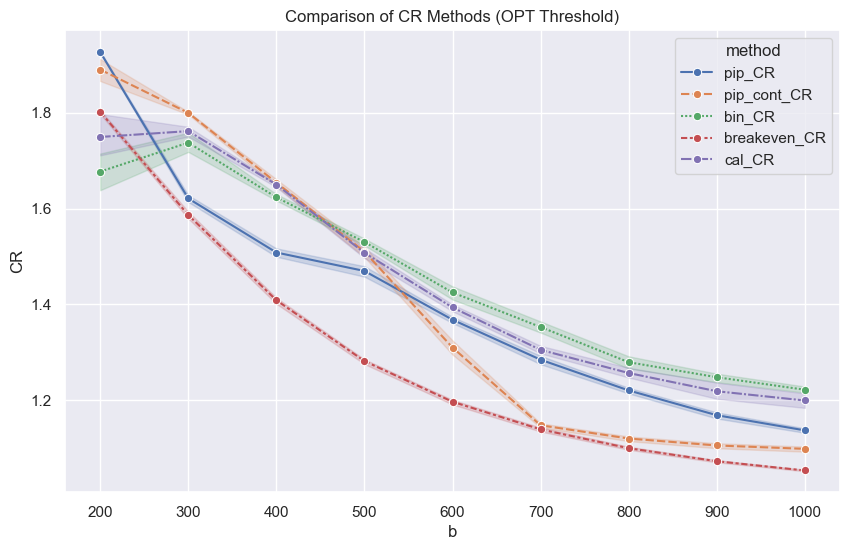

In [62]:
# Melt the DataFrame
melted_df = pd.melt(CR_df, 
                    # Keep b and i as id variables
                    id_vars=['b', 'i'],
                    # Select the CR columns to melt
                    value_vars=['pip_CR','pip_cont_CR', 'bin_CR', 'breakeven_CR', 'cal_CR'],
                    # Name the new columns
                    var_name='method',
                    value_name='CR')

# Now you can plot using seaborn
import seaborn as sns
import matplotlib.pyplot as plt

# Create the line plot with confidence intervals
plt.figure(figsize=(10, 6))
sns.lineplot(data=melted_df,
             x='b',
             y='CR',
             hue='method',
             style='method',
             marker='o')  # This will add 95% confidence intervals

plt.title('Comparison of CR Methods (OPT Threshold)')
plt.xlabel('b')
plt.ylabel('CR')

## Debugging 

In [74]:
results_df = debug_dict[400]

In [75]:
# debug pip 
row = results_df.iloc[80]
print(row[['pip_cont_CR', 'cal_CR']])
print(row['cal_day'], row['clf_prob'], row['reg_high_cont'], row['y'])
print(row['pip_cont_day'], b, row['reg_low_cont'], row['reg_high_cont'], row['y'])
sr.pip_alg(u=row['reg_high_cont'], 
           l=row['reg_low_cont'], 
           delta=row['delta'], 
           b=b)


pip_cont_CR    2.0
cal_CR         2.0
Name: 80, dtype: object
400.0 0.5454545454545454 1149.1633475974936 788
400 1000 0.001 1149.1633475974936 788


np.float64(1149.1633475974936)

In [76]:
## compare df 
compare_CR='pip_CR'
compare_day = 'pip_day'
results_df['worse'] = results_df['cal_CR'] > results_df[compare_CR]
results_df['better'] = results_df['cal_CR'] < results_df[compare_CR]

In [77]:
worst_df = results_df[results_df['worse'] == True]
worst_df.groupby(['cal_CR', 'clf_prob', compare_CR, 'y', 'cal_day', compare_day]).count()

reg_pred_cont  \
cal_CR   clf_prob pip_CR y   cal_day    pip_day                     
1.281161 1.000000 1.1675 467 112.464311 551.580632              1   
1.303980 1.000000 1.0000 393 112.464311 544.992789              1   
1.310650 1.000000 1.0000 391 112.464311 553.657736              1   
1.427790 0.909091 1.0425 417 171.115845 522.214573              1   
                  1.3000 520 171.115845 536.065176              1   
...                                                           ...   
2.000000 0.818182 1.2750 510 400.000000 521.010356              1   
                  1.3225 529 400.000000 536.523342              1   
2.009664 1.000000 1.0000 255 112.464311 562.143293              1   
2.340639 0.909091 1.0000 244 171.115845 490.042401              1   
2.504894 0.909091 1.0000 228 171.115845 514.468146              1   

                                                    reg_low_cont  \
cal_CR   clf_prob pip_CR y   cal_day    pip_day                    
1.281161 1.000000 1.1675 467 112.464311 551.580632             1   
1.303980 1.000000 1.0000 393 112.464311 544.992789             1   
1.310650 1.000000 1.0000 391 112.464311 553.657736             1   
1.427790 0.909091 1.0425 417 171.115845 522.214573             1   
                  1.3000 520 171.115845 536.065176             1   
...                                                          ...   
2.000000 0.818182 1.2750 510 400.000000 521.010356             1   
                  1.3225 529 400.000000 536.523342             1   
2.009664 1.000000 1.0000 255 112.464311 562.143293             1   
2.340639 0.909091 1.0000 244 171.115845 490.042401             1   
2.504894 0.909091 1.0000 228 171.115845 514.468146             1   

                                                    reg_high_cont  reg_pred  \
cal_CR   clf_prob pip_CR y   cal_day    pip_day                               
1.281161 1.000000 1.1675 467 112.464311 551.580632              1         1   
1.303980 1.000000 1.0000 393 112.464311 544.992789              1         1   
1.310650 1.000000 1.0000 391 112.464311 553.657736              1         1   
1.427790 0.909091 1.0425 417 171.115845 522.214573              1         1   
                  1.3000 520 171.115845 536.065176              1         1   
...                                                           ...       ...   
2.000000 0.818182 1.2750 510 400.000000 521.010356              1         1   
                  1.3225 529 400.000000 536.523342              1         1   
2.009664 1.000000 1.0000 255 112.464311 562.143293              1         1   
2.340639 0.909091 1.0000 244 171.115845 490.042401              1         1   
2.504894 0.909091 1.0000 228 171.115845 514.468146              1         1   

                                                    reg_low  reg_high  y_bin  \
cal_CR   clf_prob pip_CR y   cal_day    pip_day                                
1.281161 1.000000 1.1675 467 112.464311 551.580632        1         1      1   
1.303980 1.000000 1.0000 393 112.464311 544.992789        1         1      1   
1.310650 1.000000 1.0000 391 112.464311 553.657736        1         1      1   
1.427790 0.909091 1.0425 417 171.115845 522.214573        1         1      1   
                  1.3000 520 171.115845 536.065176        1         1      1   
...                                                     ...       ...    ...   
2.000000 0.818182 1.2750 510 400.000000 521.010356        1         1      1   
                  1.3225 529 400.000000 536.523342        1         1      1   
2.009664 1.000000 1.0000 255 112.464311 562.143293        1         1      1   
2.340639 0.909091 1.0000 244 171.115845 490.042401        1         1      1   
2.504894 0.909091 1.0000 228 171.115845 514.468146        1         1      1   

                                                    delta  clf_pred  eps  \
cal_CR   clf_prob pip_CR y   cal_day    pip_day                            
1.281161 1.000000 1.1675 467 112.464311 551.5806